<a href="https://colab.research.google.com/github/OmarChocamani/SIS420-OCL/blob/main/Copia_de_reg_log_onevsall_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np
import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# modulo para cargar archivos en formato MATLAB
# from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [3]:
data= pd.read_csv('/content/drive/MyDrive/SIS420/MiDataSets/gcar_data.csv')
#data.info()
#print(data)

In [4]:
#Se agragan las 3 columnas necesarias
# Crear una nueva columna que describe el estado basado en el kilometraje
data['estado'] = data['mileage_in_km'].apply(lambda x: 'Excelente' if x < 50000 else 'Usado')
# Crear una columna booleana indicando si el auto tiene transmisión automática
data['es_automatico'] = data['transmission_type'].apply(lambda x: True if x == 'Automático' else False)
# Crear una columna que combine la potencia y el tipo de combustible
data['descripcion_auto'] = data.apply(lambda row: f"{row['power_kw']} KW - {row['fuel_type']}", axis=1)
print(data)

       Unnamed: 0       brand                 model  color registration_date  \
0           75721        ford             Ford Kuga  black           05/2023   
1           80184     hyundai           Hyundai i10  black           09/2018   
2           19864        audi        Audi Q4 e-tron   grey           05/2021   
3           76699       honda            Honda CR-V    red           07/2018   
4           92991         kia          Kia Sportage  black           02/2023   
...           ...         ...                   ...    ...               ...   
99995        6265        audi               Audi A1   blue           05/2012   
99996       54886        fiat              Fiat 500  black           12/2019   
99997       76820       honda            Honda CR-V  brown           01/2019   
99998         860  alfa-romeo  Alfa Romeo Giulietta   grey           12/2020   
99999       15795        audi               Audi A3  black           05/2018   

       year price_in_euro power_kw powe

In [5]:
#data.info()

In [6]:
#Preprocesamiento de datos para asignar a cada valor unico de la columna brand un numero entero
#Ademas observaremos la cantidad e etiquetas que tendra
to_convert = ['brand']
id2label = {}
label2id = {}
for col in to_convert:
    id2label[col] = {i: cls for i, cls in enumerate(data[col].unique())}
    label2id[col] = {cls: i for i, cls in id2label[col].items()}
    data[col] = data[col].replace(label2id[col])
    print(label2id[col])

{'ford': 0, 'hyundai': 1, 'audi': 2, 'honda': 3, 'kia': 4, 'dacia': 5, 'bmw': 6, 'citroen': 7, 'alfa-romeo': 8, 'land-rover': 9, 'jaguar': 10, 'dodge': 11, 'fiat': 12, 'lamborghini': 13, 'mazda': 14, 'isuzu': 15, 'jeep': 16, 'ferrari': 17, 'bentley': 18, 'maserati': 19, 'daihatsu': 20, 'chevrolet': 21, 'aston-martin': 22, 'cadillac': 23, 'daewoo': 24, 'chrysler': 25, 'lancia': 26, 'lada': 27, 'infiniti': 28}


In [7]:
num_labels = 29

In [8]:
#variables categoricas
columnas_categoricas = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for columna in columnas_categoricas:
    data[columna] = le.fit_transform(data[columna]).astype(float)


In [9]:
data.info()
#print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  int64  
 1   brand                     100000 non-null  int64  
 2   model                     100000 non-null  float64
 3   color                     100000 non-null  float64
 4   registration_date         100000 non-null  float64
 5   year                      100000 non-null  float64
 6   price_in_euro             100000 non-null  float64
 7   power_kw                  100000 non-null  float64
 8   power_ps                  100000 non-null  float64
 9   transmission_type         100000 non-null  float64
 10  fuel_type                 100000 non-null  float64
 11  fuel_consumption_l_100km  100000 non-null  float64
 12  fuel_consumption_g_km     100000 non-null  float64
 13  mileage_in_km             99932 non-null   fl

In [10]:
data['es_automatico'] = data['es_automatico'].astype(float)
data['Unnamed: 0'] = data['Unnamed: 0'].astype(float)
data['brand'] = data['brand'].astype(float)

In [11]:
#print(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  float64
 1   brand                     100000 non-null  float64
 2   model                     100000 non-null  float64
 3   color                     100000 non-null  float64
 4   registration_date         100000 non-null  float64
 5   year                      100000 non-null  float64
 6   price_in_euro             100000 non-null  float64
 7   power_kw                  100000 non-null  float64
 8   power_ps                  100000 non-null  float64
 9   transmission_type         100000 non-null  float64
 10  fuel_type                 100000 non-null  float64
 11  fuel_consumption_l_100km  100000 non-null  float64
 12  fuel_consumption_g_km     100000 non-null  float64
 13  mileage_in_km             99932 non-null   fl

In [12]:
#llenar datos vacios
columnas_especificas = ['mileage_in_km']
media_columnas = data[columnas_especificas].mean()
data[columnas_especificas] = data[columnas_especificas].fillna(media_columnas)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  float64
 1   brand                     100000 non-null  float64
 2   model                     100000 non-null  float64
 3   color                     100000 non-null  float64
 4   registration_date         100000 non-null  float64
 5   year                      100000 non-null  float64
 6   price_in_euro             100000 non-null  float64
 7   power_kw                  100000 non-null  float64
 8   power_ps                  100000 non-null  float64
 9   transmission_type         100000 non-null  float64
 10  fuel_type                 100000 non-null  float64
 11  fuel_consumption_l_100km  100000 non-null  float64
 12  fuel_consumption_g_km     100000 non-null  float64
 13  mileage_in_km             100000 non-null  fl

In [13]:
data_copy = data.copy()

# Aumentar solo los valores decimales en el DataFrame duplicado
# Especificar las columnas numéricas en las que deseas aumentar los decimales
decimal_columns = ['Unnamed: 0','model','color','registration_date','year','price_in_euro','power_kw','power_ps','fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km','offer_description','descripcion_auto']

# Asegurarse de que las columnas sean del tipo adecuado
#for col in decimal_columns:
 #   data_copy[col] = pd.to_numeric(data_copy[col], errors='coerce')

# Filtrar filas con valores no válidos (NaN) en columnas decimales
#data_copy = data_copy.dropna(subset=decimal_columns)

# Aumentar los valores decimales en las columnas especificadas
for col in decimal_columns:
    data_copy[col] = data_copy[col] + np.random.uniform(0.1, 0.7, size=len(data_copy))


# Asegurarse de que los valores estén dentro de rangos razonables
for col in decimal_columns:
    data_copy[col] = data_copy[col].clip(lower=0)

# Concatenar los DataFrames originales y modificados
nuevo_data = pd.concat([data, data_copy], ignore_index=True)

# Guardar el dataset aumentado en un nuevo archivo CSV
nuevo_data.to_csv('ruta_del_archivo_modificado.csv', index=False)

# Ver las primeras filas del DataFrame aumentado
#print(nuevo_data.head())

In [14]:
print(nuevo_data.iloc[190000])
#print(nuevo_data)

Unnamed: 0                   44990.523734
brand                            7.000000
model                          247.380571
color                            7.235458
registration_date              110.169219
year                            33.658053
price_in_euro                 1205.634335
power_kw                       476.347708
power_ps                        20.281498
transmission_type                1.000000
fuel_type                       42.372224
fuel_consumption_l_100km       201.332423
fuel_consumption_g_km          928.168485
mileage_in_km               117000.341183
offer_description            34289.174093
estado                           1.000000
es_automatico                    0.000000
descripcion_auto              1022.153982
Name: 190000, dtype: float64


In [15]:
nuevo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                200000 non-null  float64
 1   brand                     200000 non-null  float64
 2   model                     200000 non-null  float64
 3   color                     200000 non-null  float64
 4   registration_date         200000 non-null  float64
 5   year                      200000 non-null  float64
 6   price_in_euro             200000 non-null  float64
 7   power_kw                  200000 non-null  float64
 8   power_ps                  200000 non-null  float64
 9   transmission_type         200000 non-null  float64
 10  fuel_type                 200000 non-null  float64
 11  fuel_consumption_l_100km  200000 non-null  float64
 12  fuel_consumption_g_km     200000 non-null  float64
 13  mileage_in_km             200000 non-null  f

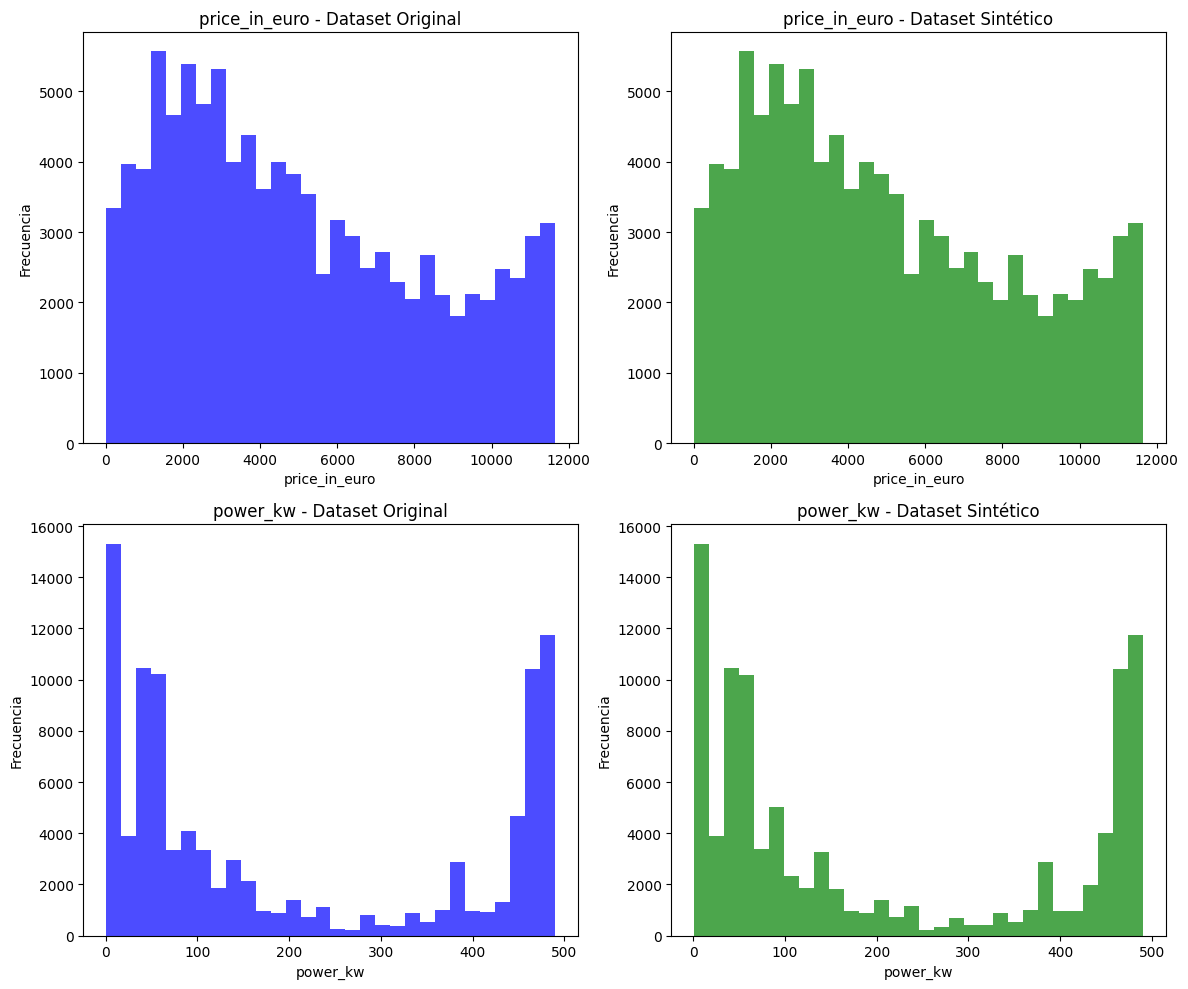

In [16]:
# Cargar los datasets originales y sintéticos
#data_original = pd.read_csv('ruta_del_archivo_original.csv')
#data_sintetico = pd.read_csv('ruta_del_archivo_modificado.csv')

# Especificar las columnas numéricas que queremos graficar
columnas_numericas = ['price_in_euro', 'power_kw']

# Crear una figura para comparar cada atributo entre los datasets
fig, axs = pyplot.subplots(len(columnas_numericas), 2, figsize=(12, 5 * len(columnas_numericas)))

# Iterar sobre las columnas numéricas y generar gráficos
for i, col in enumerate(columnas_numericas):
    # Graficar el dataset original
    axs[i, 0].hist(data[col].dropna(), bins=30, color='blue', alpha=0.7)
    axs[i, 0].set_title(f'{col} - Dataset Original')
    axs[i, 0].set_xlabel(col)
    axs[i, 0].set_ylabel('Frecuencia')

    # Graficar el dataset sintético
    axs[i, 1].hist(data_copy[col].dropna(), bins=30, color='green', alpha=0.7)
    axs[i, 1].set_title(f'{col} - Dataset Sintético')
    axs[i, 1].set_xlabel(col)
    axs[i, 1].set_ylabel('Frecuencia')

# Ajustar el espacio entre gráficos
pyplot.tight_layout()
pyplot.show()


In [17]:
X_datos=nuevo_data.iloc[:,[2,3,4,5,6,7,8,9,10,11,12,13,14]]
y_datos=nuevo_data.iloc[:,1]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_datos, y_datos, test_size=0.2)
X_train.shape, X_test.shape

((160000, 13), (40000, 13))

In [19]:
X=X_train
y=y_train
print(y)

44914      7.0
96883      2.0
3459      10.0
145584     2.0
35627      3.0
          ... 
21819      0.0
58022     10.0
23428      2.0
106685     4.0
20602      0.0
Name: brand, Length: 160000, dtype: float64


In [20]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [21]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

In [22]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
# X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
X = X_norm
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [23]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [117]:
J_history=[]
P_history=[]
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
    # Inicializa algunos valores utiles
    #J_history=[]
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

#     J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)

#    P_history.append(h)
#     theta = theta - (alpha / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    predictions = (h >= 0.5).astype(int)  # Umbral de 0.5 para clasificar
    correct_predictions = np.sum(predictions == y)  # Contar predicciones correctas
    precision = correct_predictions / m  # Precisión como proporción de predicciones correctas

    J_history.append(J)
    P_history.append(precision)

    return J, grad
#    return J, theta


In [145]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles

    m, n = X.shape
    all_J_history=[]

    all_theta = np.zeros((num_labels, n + 1))



    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        print(f"Entrenando para la clase {c}...")
        initial_theta = np.zeros(n + 1)

        options = {'maxiter': 50}
        #J_history=[]
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[c] = res.x
        all_J_history.append(J_history[c].copy())


    return all_theta, all_J_history

In [147]:
lambda_ = 0.1
all_theta, all_J_history = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

Entrenando para la clase 0...
Entrenando para la clase 1...
Entrenando para la clase 2...
Entrenando para la clase 3...
Entrenando para la clase 4...
Entrenando para la clase 5...
Entrenando para la clase 6...
Entrenando para la clase 7...
Entrenando para la clase 8...
Entrenando para la clase 9...
Entrenando para la clase 10...
Entrenando para la clase 11...
Entrenando para la clase 12...
Entrenando para la clase 13...
Entrenando para la clase 14...
Entrenando para la clase 15...
Entrenando para la clase 16...
Entrenando para la clase 17...
Entrenando para la clase 18...
Entrenando para la clase 19...
Entrenando para la clase 20...
Entrenando para la clase 21...
Entrenando para la clase 22...
Entrenando para la clase 23...
Entrenando para la clase 24...
Entrenando para la clase 25...
Entrenando para la clase 26...
Entrenando para la clase 27...
Entrenando para la clase 28...
(29, 14)


In [148]:
print(all_J_history)
#print(P_history)

[0.6931471805599573, 0.5854845545690677, 0.42492721074920586, 0.418969135256233, 0.40872557072027604, 0.4064419179317131, 0.40062688566788723, 0.400381188150338, 0.39968520870140745, 0.3994307310364576, 0.39925229818366464, 0.39882300087200256, 0.39880630703361947, 0.3987698046512661, 0.3987657197927855, 0.39875253335990923, 0.39874118530872293, 0.3987377307298857, 0.398729635137355, 0.39872919686336583, 0.398728079226117, 0.39872795616358137, 0.3987275322682393, 0.39872690952679757, 0.39872676748761304, 0.3987264123013734, 0.3987263831315222, 0.3987263042872269, 0.39872629765661555]


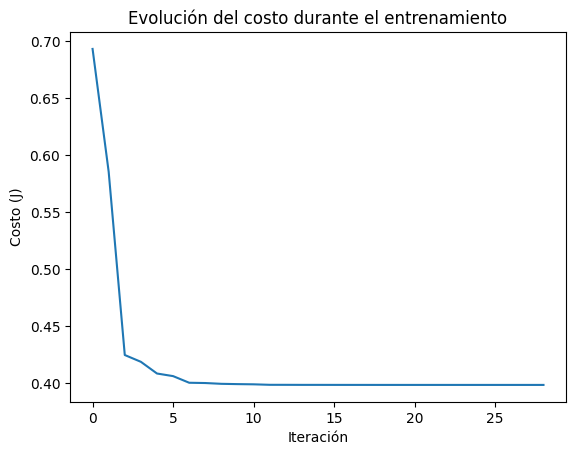

In [149]:
pyplot.plot(all_J_history)
pyplot.xlabel('Iteración')
pyplot.ylabel('Costo (J)')
pyplot.title('Evolución del costo durante el entrenamiento')
pyplot.show()

In [150]:
print(all_theta)

[[-1.88547214e+00  1.03036843e+00  1.38633978e-01  2.22816235e-02
  -1.30953120e-01  6.12296936e-02  1.23186189e-01 -3.65054698e-01
   4.88632641e-01 -1.31516836e-01 -3.49831282e-02  7.85779516e-02
   4.86566957e-02  8.19497030e-02]
 [-3.61396095e+00  1.48597713e+00  6.46116655e-02  3.64695561e-02
   2.89982428e-01 -8.60279379e-02  1.00420952e-01  3.58105958e-03
   1.47511568e-01  2.41655308e-01  1.22095049e-01 -2.39125343e-01
  -2.15928877e-02 -6.95321584e-02]
 [-1.35464220e+01 -1.25177108e+01  9.99541078e-02 -7.67174122e-02
   4.10307614e-01 -1.48796677e-01 -2.37457607e-02  5.32809786e-01
  -2.11249563e-01 -1.14664369e-01  3.83229816e-01  1.77073997e-01
   3.33382745e-01 -4.45707590e-01]
 [-5.66481477e+00  8.49459004e-01 -1.23735561e-01  7.70805213e-03
   1.04593937e-01 -2.00485003e-01 -3.81777713e-02 -4.53602917e-01
  -3.93092925e-02  3.94041133e-01  7.73857035e-02  6.89185164e-02
  -2.43499085e-01 -5.79615339e-01]
 [-6.62991621e+00  3.64931671e+00  1.24575672e-01  1.05250933e-01
  

In [151]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p



In [153]:
X_Nor_test, mu, sigma = featureNormalize(X_test)
#print(X_Nor_test)

pred = predictOneVsAll(all_theta, X_Nor_test)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y_test) * 100))

#num_epochs = 50
#precisions = []

# Selecciona las primeras 150 filas de X
XPrueba = X_Nor_test.iloc[0:150, :].copy()
#XPrueba = np.concatenate([np.ones((150, 1)), XPrueba], axis=1)
#print(XPrueba[0])
#for epoch in range(num_epochs):
p = predictOneVsAll(all_theta, XPrueba)
#precision = np.mean(pred == y_test) * 100
#precisions.append(precision)
#print(XPrueba[0])
#p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis=1)

print("Predicciones")
print(p)

# Muestra los datos reales de prueba
print("Datos reales de prueba")
print(y_test[0:150].tolist())

Precision del conjuto de entrenamiento: 67.54%
Predicciones
[18  0  5  2  6  6  6 14 12  6  2  0  2  6  0  0  2  9  6  6  0  2  2  2
  2  4  2  2  0  2  6  0  0  0  2  4  2  6  2  0  0  6  6  6 12  4 12  6
 12  2  6  6  2 14  2  2  0  6  2  9  6  6  0  6  0  0 12  0  0  6  6  6
 12  6  0  6  0  0  2  4  2  2  2  0  0  0  5  6  6  6  2  2  6  0  2  0
  6  4  0  6 19  6  0  6  0  2  0  0  0  6  0  0  0 12  6  9  0  2 12  2
  0  0  0  6  0  9  0  4  4  0  2  2  6 12  2  6  0  6  2  6  2  0  0 12
  2  2  2  2  0 17]
Datos reales de prueba
[17.0, 0.0, 7.0, 2.0, 2.0, 6.0, 6.0, 14.0, 0.0, 6.0, 2.0, 0.0, 2.0, 7.0, 1.0, 0.0, 2.0, 9.0, 6.0, 6.0, 12.0, 2.0, 2.0, 22.0, 2.0, 4.0, 2.0, 2.0, 0.0, 2.0, 6.0, 0.0, 0.0, 16.0, 2.0, 4.0, 2.0, 6.0, 2.0, 1.0, 5.0, 6.0, 6.0, 6.0, 12.0, 4.0, 12.0, 6.0, 12.0, 2.0, 6.0, 6.0, 8.0, 14.0, 2.0, 2.0, 4.0, 6.0, 2.0, 9.0, 6.0, 6.0, 16.0, 6.0, 0.0, 27.0, 12.0, 0.0, 10.0, 6.0, 0.0, 6.0, 12.0, 6.0, 1.0, 6.0, 0.0, 1.0, 2.0, 9.0, 8.0, 8.0, 2.0, 5.0, 12.0, 0.0, 5.0, 23.0, 18

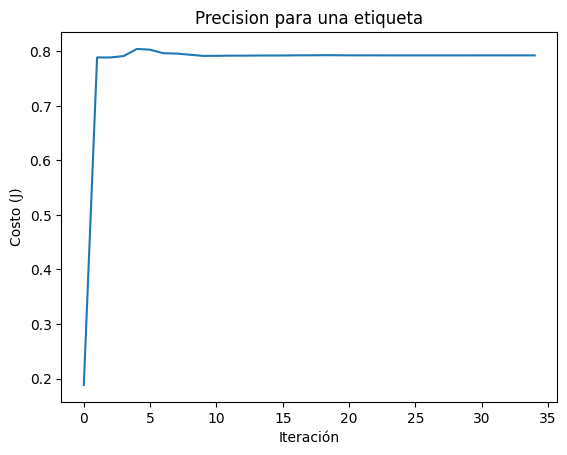

In [159]:
pyplot.plot(P_history[0:35])
pyplot.xlabel('Iteración')
pyplot.ylabel('Costo (J)')
pyplot.title('Precision para una etiqueta')
pyplot.show()